# Mushroom Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

random_state = np.random.seed(12)
pd.set_option('display.max_columns', None)

## 1 - Obtaining the Initial Dataset

In [2]:
mushrooms_dataset = fetch_ucirepo(id=73)

In [3]:
initial_features = mushrooms_dataset.data.features
initial_targets = mushrooms_dataset.data.targets

processed_features = initial_features.copy()
processed_targets = initial_targets.copy()

In [4]:
initial_features

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,NaN,s,s,o,o,p,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,NaN,s,s,o,o,p,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,NaN,s,s,o,o,p,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,NaN,s,k,w,w,p,w,o,e,w,v,l


In [5]:
initial_targets

,poisonous
0,p
1,e
2,e
3,p
4,e
...,...
8119,e
8120,e
8121,e
8122,p


## 2 - Processing the Dataset

### 2.1 - Processing Ordinal Categorical Feature Values

In [6]:
def ordinal(initial, key, values):
    data = initial.copy()
    data[key] = initial[key].apply(lambda value: values.index(value))
    return data

#### 2.1.1 - Gill-Spacing

- c = close -> 0
- w = crowded -> 1
- d = distant -> 2

In [7]:
print(f"Initial Value Counts\n{processed_features['gill-spacing'].value_counts()}\n")
processed_features = ordinal(processed_features, 'gill-spacing', ['c', 'w', 'd'])
print(f"Final Value Counts\n{processed_features['gill-spacing'].value_counts()}")

Initial Value Counts
gill-spacing
c    6812
w    1312
Name: count, dtype: int64

Final Value Counts
gill-spacing
0    6812
1    1312
Name: count, dtype: int64


#### 2.1.2 - Gill-Size

- n = narrow -> 0
- b = broad -> 1

In [8]:
print(f"Initial Value Counts\n{processed_features['gill-size'].value_counts()}\n")
processed_features = ordinal(processed_features, 'gill-size', ['n', 'b'])
print(f"Final Value Counts\n{processed_features['gill-size'].value_counts()}")

Initial Value Counts
gill-size
b    5612
n    2512
Name: count, dtype: int64

Final Value Counts
gill-size
1    5612
0    2512
Name: count, dtype: int64


#### 2.1.3 - Ring-Number

- n = none -> 0
- o = one -> 1
- t = two -> 2

In [9]:
print(f"Initial Value Counts\n{processed_features['ring-number'].value_counts()}\n")
processed_features = ordinal(processed_features, 'ring-number', ['n', 'o', 't'])
print(f"Final Value Counts\n{processed_features['ring-number'].value_counts()}")

Initial Value Counts
ring-number
o    7488
t     600
n      36
Name: count, dtype: int64

Final Value Counts
ring-number
1    7488
2     600
0      36
Name: count, dtype: int64


#### 2.1.4 - Population

- y = solitary -> 0
- v = several -> 1
- s = scattered -> 2
- n = numerous -> 3
- c = clustered -> 4
- a = abundant -> 5

In [10]:
print(f"Initial Value Counts\n{processed_features['population'].value_counts()}\n")
processed_features = ordinal(processed_features, 'population', ['y', 'v', 's', 'n', 'c', 'a'])
print(f"Final Value Counts\n{processed_features['population'].value_counts()}")

Initial Value Counts
population
v    4040
y    1712
s    1248
n     400
a     384
c     340
Name: count, dtype: int64

Final Value Counts
population
1    4040
0    1712
2    1248
3     400
5     384
4     340
Name: count, dtype: int64


### 2.2 - Processing Non-Ordinal Categorical Feature Values

In [11]:
def non_ordinal(initial, key, values):
    data = initial.copy()
    for value in values:
        data[f"{value}-{key}"] = (initial[key] == value).astype(int)
    data.drop([key], axis=1, inplace=True)
    return data

#### 2.2.1 - Cap-Shape

- b = bell
- c = conical
- x = convex
- f = flat
- k = knobbed
- s = sunken

In [12]:
processed_features = non_ordinal(processed_features, 'cap-shape', ['b', 'c', 'x', 'f', 'k', 's'])

#### 2.2.2 - Cap-Surface

- f = fibrous
- g = grooves
- y = scaly
- s = smooth

In [13]:
processed_features = non_ordinal(processed_features, 'cap-surface', ['f', 'g', 'y', 's'])

#### 2.2.3 - Cap-Colour

- n = brown
- b = buff
- c = cinnamon
- g = gray
- r = green
- p = pink
- u = purple
- e = red
- w = white
- y = yellow

In [14]:
processed_features = non_ordinal(processed_features, 'cap-color', ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'])

#### 2.2.4 - Bruises

- t = bruises
- f = no bruises

In [15]:
processed_features = non_ordinal(processed_features, 'bruises', ['t', 'f'])

#### 2.2.5 - Odour

- a = almond
- l = anise
- c = creosote
- y = fishy
- f = foul
- m = musty
- n = none
- p = pungent
- s = spicy

In [16]:
processed_features = non_ordinal(processed_features, 'odor', ['a', 'l', 'c', 'y', 'f', 'm', 'n', 'p', 's'])

#### 2.2.6 - Gill-Attachment

- a = attached
- d = descending
- f = free
- n = notched

In [17]:
processed_features = non_ordinal(processed_features, 'gill-attachment', ['a', 'd', 'f', 'n'])

#### 2.2.7 - Gill-Colour

- k = black
- n = brown
- b = buff
- h = chocolate
- g = gray
- r = green
- o = orange
- p = pink
- u = purple
- e = red
- w = white
- y = yellow

In [18]:
processed_features = non_ordinal(processed_features, 'gill-color', ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'])

#### 2.2.8 - Stalk-Shape

- e = enlarging
- t = tapering

In [19]:
processed_features = non_ordinal(processed_features, 'stalk-shape', ['e', 't'])

#### 2.2.9 - Stalk-Root

- b = bulbous
- c = club
- u = cup
- e = equal
- z = rhizomorphs
- r = rooted

In [20]:
processed_features = non_ordinal(processed_features, 'stalk-root', ['b', 'c', 'u', 'e', 'z', 'r'])

#### 2.2.10 - Stalk-Surface-Above-Ring

- f = fibrous
- y = scaly
- k = silky
- s = smooth

In [21]:
processed_features = non_ordinal(processed_features, 'stalk-surface-above-ring', ['f', 'y', 'k', 's'])

#### 2.2.11 - Stalk-Surface-Below-Ring

- f = fibrous
- y = scaly
- k = silky
- s = smooth

In [22]:
processed_features = non_ordinal(processed_features, 'stalk-surface-below-ring', ['f', 'y', 'k', 's'])

#### 2.2.12 - Stalk-Colour-Above-Ring

- n = brown
- b = buff
- c = cinnamon
- g = gray
- o = orange
- p = pink
- e = red
- w = white
- y = yellow

In [23]:
processed_features = non_ordinal(processed_features, 'stalk-color-above-ring', ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'])

#### 2.2.13 - Stalk-Colour-Below-Ring

- n = brown
- b = buff
- c = cinnamon
- g = gray
- o = orange
- p = pink
- e = red
- w = white
- y = yellow

In [24]:
processed_features = non_ordinal(processed_features, 'stalk-color-below-ring', ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'])

#### 2.2.14 - Veil-Type

- p = partial
- u = universal

In [25]:
processed_features = non_ordinal(processed_features, 'veil-type', ['p', 'u'])

#### 2.2.15 - Veil-Colour

- n = brown
- o = orange
- w = white
- y = yellow

In [26]:
processed_features = non_ordinal(processed_features, 'veil-color', ['n', 'o', 'w', 'y'])

#### 2.2.16 - Ring-Type

- c = cobwebby
- e = evanescent
- f = flaring
- l = large
- n = none
- p = pendant
- s = sheathing
- z = zone

In [27]:
processed_features = non_ordinal(processed_features, 'ring-type', ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'])

#### 2.2.17 - Spore-Print-Colour

- k = black
- n = brown
- b = buff
- h = chocolate
- r = green
- o = orange
- u = purple
- w = white
- y = yellow

In [28]:
processed_features = non_ordinal(processed_features, 'spore-print-color', ['k', 'n', 'b', 'h', 'r', 'o', 'u', 'w', 'y'])

#### 2.2.18 - Habitat

- g = grasses
- l = leaves
- m = meadows
- p = paths
- u = urban
- w = waste
- d = woods

In [29]:
processed_features = non_ordinal(processed_features, 'habitat', ['g', 'l', 'm', 'p', 'u', 'w', 'd'])

### 2.3 - Validating the Processed Feature Values

In [30]:
print("Shape =", initial_features.shape)
initial_features

Shape = (8124, 22)


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,NaN,s,s,o,o,p,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,NaN,s,s,o,o,p,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,NaN,s,s,o,o,p,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,NaN,s,k,w,w,p,w,o,e,w,v,l


In [31]:
print("Shape =", processed_features.shape)
processed_features

Shape = (8124, 115)


,gill-spacing,gill-size,ring-number,population,b-cap-shape,c-cap-shape,x-cap-shape,f-cap-shape,k-cap-shape,s-cap-shape,f-cap-surface,g-cap-surface,y-cap-surface,s-cap-surface,n-cap-color,b-cap-color,c-cap-color,g-cap-color,r-cap-color,p-cap-color,u-cap-color,e-cap-color,w-cap-color,y-cap-color,t-bruises,f-bruises,a-odor,l-odor,c-odor,y-odor,f-odor,m-odor,n-odor,p-odor,s-odor,a-gill-attachment,d-gill-attachment,f-gill-attachment,n-gill-attachment,k-gill-color,n-gill-color,b-gill-color,h-gill-color,g-gill-color,r-gill-color,o-gill-color,p-gill-color,u-gill-color,e-gill-color,w-gill-color,y-gill-color,e-stalk-shape,t-stalk-shape,b-stalk-root,c-stalk-root,u-stalk-root,e-stalk-root,z-stalk-root,r-stalk-root,f-stalk-surface-above-ring,y-stalk-surface-above-ring,k-stalk-surface-above-ring,s-stalk-surface-above-ring,f-stalk-surface-below-ring,y-stalk-surface-below-ring,k-stalk-surface-below-ring,s-stalk-surface-below-ring,n-stalk-color-above-ring,b-stalk-color-above-ring,c-stalk-color-above-ring,g-stalk-color-above-ring,o-stalk-color-above-ring,p-stalk-color-above-ring,e-stalk-color-above-ring,w-stalk-color-above-ring,y-stalk-color-above-ring,n-stalk-color-below-ring,b-stalk-color-below-ring,c-stalk-color-below-ring,g-stalk-color-below-ring,o-stalk-color-below-ring,p-stalk-color-below-ring,e-stalk-color-below-ring,w-stalk-color-below-ring,y-stalk-color-below-ring,p-veil-type,u-veil-type,n-veil-color,o-veil-color,w-veil-color,y-veil-color,c-ring-type,e-ring-type,f-ring-type,l-ring-type,n-ring-type,p-ring-type,s-ring-type,z-ring-type,k-spore-print-color,n-spore-print-color,b-spore-print-color,h-spore-print-color,r-spore-print-color,o-spore-print-color,u-spore-print-color,w-spore-print-color,y-spore-print-color,g-habitat,l-habitat,m-habitat,p-habitat,u-habitat,w-habitat,d-habitat
0,0,0,1,2,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,1,3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,1,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,1,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,1,5,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,1,1,4,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
8120,0,1,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
8121,0,1,1,4,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

### 2.4 - Processing Binary Target Values

In [32]:
print(f"Initial Value Counts\n{processed_targets['poisonous'].value_counts()}\n")
processed_targets = ordinal(processed_targets, 'poisonous', ['e', 'p'])
print(f"Final Value Counts\n{processed_targets['poisonous'].value_counts()}")

Initial Value Counts
poisonous
e    4208
p    3916
Name: count, dtype: int64

Final Value Counts
poisonous
0    4208
1    3916
Name: count, dtype: int64


### 2.5 - Validating the Processed Target Values

In [33]:
print("Shape =", initial_targets.shape)
initial_targets

Shape = (8124, 1)


,poisonous
0,p
1,e
2,e
3,p
4,e
...,...
8119,e
8120,e
8121,e
8122,p


In [34]:
print("Shape =", processed_targets.shape)
processed_targets

Shape = (8124, 1)


,poisonous
0,1
1,0
2,0
3,1
4,0
...,...
8119,0
8120,0
8121,0
8122,1


## 3 - Splitting the Dataset

In [35]:
split_proportion = 0.7
dataset_size = processed_features.shape[0]
train_size = int(dataset_size * split_proportion)
test_size = dataset_size - train_size

In [36]:
x_train, y_train = processed_features.iloc[train_size:], processed_targets.iloc[train_size:]['poisonous']
x_test, y_test = processed_features.iloc[:train_size], processed_targets.iloc[:train_size]['poisonous']

print(f"Shape of x_train = {x_train.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of x_test = {x_test.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of x_train = (2438, 115)
Shape of y_train = (2438,)
Shape of x_test = (5686, 115)
Shape of y_test = (5686,)


## 4 - Supervised Model

Accuracy = 0.48558

In [37]:
def display_results(accuracy, confusion_matrix, classification_report, predictions):
    print(f"Accuracy = {accuracy:.5f}\n")
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=np.unique(predictions))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
    print(classification_report)

In [38]:
def train_test_eval(model, x_train_set, y_train_set, x_test_set, y_test_set):
    model.fit(x_train_set, y_train_set)
    y_pred_set = model.predict(x_test_set).astype(int)
    results = (y_pred_set == y_test_set).value_counts()
    accuracy = float(results[True] / y_test_set.shape[0])
    return {
        "predictions": y_pred_set,
        "accuracy": accuracy,
        "confusion_matrix": confusion_matrix(y_test_set, y_pred_set),
        "classification_report": classification_report(y_test_set, y_pred_set)
    }

Accuracy = 0.48558



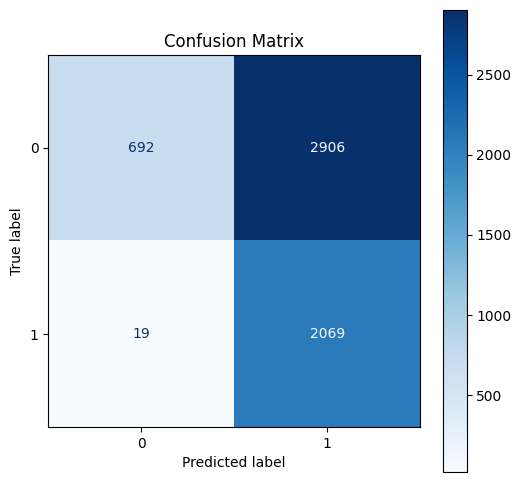

              precision    recall  f1-score   support

           0       0.97      0.19      0.32      3598
           1       0.42      0.99      0.59      2088

    accuracy                           0.49      5686
   macro avg       0.69      0.59      0.45      5686
weighted avg       0.77      0.49      0.42      5686



In [51]:
logistic_regression_model = LogisticRegression(n_jobs=-1)
logistic_regression_results = train_test_eval(logistic_regression_model, x_train, y_train, x_test, y_test)
display_results(**logistic_regression_results)

## 5 - Unsupervised Model

Accuracy = 0.44636

Accuracy = 0.44636



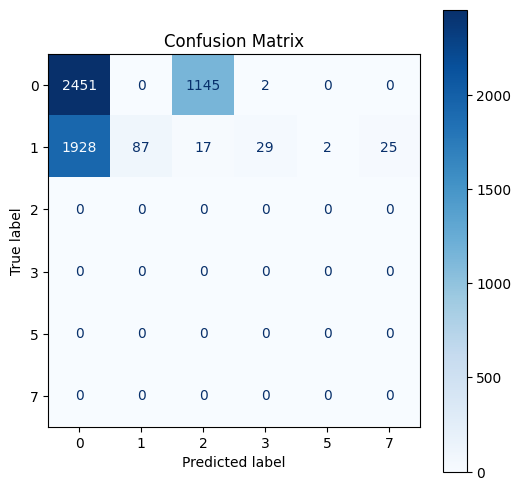

              precision    recall  f1-score   support

           0       0.56      0.68      0.61      3598
           1       1.00      0.04      0.08      2088
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.45      5686
   macro avg       0.26      0.12      0.12      5686
weighted avg       0.72      0.45      0.42      5686



In [50]:
k_means_model = KMeans()
k_means_results = train_test_eval(k_means_model, x_train, y_train, x_test, y_test)
display_results(**k_means_results)